In [31]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib
import astropy.units as u
import astropy.coordinates as coord
from astroquery.vizier import Vizier
%matplotlib inline
from astropy.io import fits
from astroquery.simbad import Simbad
import matplotlib
import aplpy
from astroquery.sdss import SDSS
from astroquery.skyview import SkyView
from astropy.coordinates import Angle
import time
from astropy.table import Table
import heapq
from math import log10, floor
import matplotlib.mlab as mlab
from bs4 import BeautifulSoup
import urllib2
from astroquery.nrao import Nrao

In [32]:
#Region of Sky:

RA=196.875
DE=51.0
RA_length=35.625
DE_length=6.0

#Catalogues:

First_Catalogue_Name='LOTSS'
Second_Catalogue_Name='TGSS'

In [33]:
#Name of Flux in Catalogue..

First_Flux='FTot'
Second_Flux='Stotal'

#And their error
First_Flux_error='e_'+First_Flux
Second_Flux_error='e_'+Second_Flux

In [34]:
#Retrieving first catalogue data:
First_Catalogue_Data= Table.read('data/'+First_Catalogue_Name+'.fit', format='fits')

#Retrieving second catalogue data:
Second_Catalogue_Data= Table.read('data/'+Second_Catalogue_Name+'.fit', format='fits')

In [35]:
#Making array for first catalogue in region of the sky chosen 

n=0
RA_First=[]
DE_First=[]
Lum_First=[]
RA_First_e=[]
DE_First_e=[]
Lum_First_e=[]
while n< len(First_Catalogue_Data):
    if RA-RA_length<First_Catalogue_Data["RAJ2000"][n] and First_Catalogue_Data["RAJ2000"][n]<RA+RA_length and DE-DE_length<First_Catalogue_Data["DEJ2000"][n] and First_Catalogue_Data["DEJ2000"][n]<DE+DE_length:
        RA_First.append(First_Catalogue_Data["RAJ2000"][n])
        DE_First.append(First_Catalogue_Data["DEJ2000"][n])
        Lum_First.append(First_Catalogue_Data[First_Flux][n]/1000)
        RA_First_e.append(First_Catalogue_Data["e_RAdegtot"][n]/3600)
        DE_First_e.append(First_Catalogue_Data["e_DEdegtot"][n]/3600)
        Lum_First_e.append(First_Catalogue_Data[First_Flux_error][n]/1000)
    n=n+1

#Making array for second catalogue in region of the sky chosen  
    
n=0
RA_Second=[]
DE_Second=[]
Lum_Second=[]
RA_Second_e=[]
DE_Second_e=[]
Lum_Second_e=[]
while n< len(Second_Catalogue_Data):
    if RA-RA_length<Second_Catalogue_Data["RAJ2000"][n] and Second_Catalogue_Data["RAJ2000"][n]<RA+RA_length and DE-DE_length<Second_Catalogue_Data["DEJ2000"][n] and Second_Catalogue_Data["DEJ2000"][n]<DE+DE_length:
        RA_Second.append(Second_Catalogue_Data["RAJ2000"][n])
        DE_Second.append(Second_Catalogue_Data["DEJ2000"][n])
        Lum_Second.append(Second_Catalogue_Data[Second_Flux][n]/1000)
        RA_Second_e.append(Second_Catalogue_Data["e_RAJ2000"][n]/3600)
        DE_Second_e.append(Second_Catalogue_Data["e_DEJ2000"][n]/3600)
        Lum_Second_e.append(Second_Catalogue_Data[Second_Flux_error][n]/1000)
    n=n+1


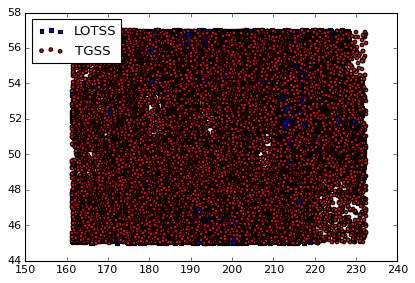

In [36]:
#Plotting coords of two arrays to compare

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(RA_First, DE_First, s=10, c='b', marker="s", label=First_Catalogue_Name)
ax1.scatter(RA_Second,DE_Second, s=10, c='r', marker="o", label=Second_Catalogue_Name)
plt.legend(loc='upper left');
plt.show()

In [37]:
start_time = time.time()
#This loop finds common stars between catalogues:

#Creating new arrays:

#Luminosities of stars in common(and error)
Lum_First_Relevant=[]
Lum_Second_Relevant=[]
Lum_First_Relevant_e=[]
Lum_Second_Relevant_e=[]

#Coordinates of stars in common(and error)
RA_First_Relevant=[]
RA_Second_Relevant=[]
DE_First_Relevant=[]
DE_Second_Relevant=[]
RA_First_Relevant_e=[]
RA_Second_Relevant_e=[]
DE_First_Relevant_e=[]
DE_Second_Relevant_e=[]

#Creating new variables

#index for first catalogue:
f=0
#index for second catalogue:
s=0
#number of iterations:
it=0
#Number of stars in both catalogues
corr=1

#While loop goes through all of first catalogue..
while f<len(RA_First):
    #If it compares a source in first catalogue to every source in second without finding one in common then..
    if s==len(RA_Second):
        #It moves on to next source in first and..
        f=f+1
        #Starts comparing it to the first source in the second catalogue
        s=0
    #This is a formula for overlapping rectangles with the sides being the error
    #If this is true catalogues have that source in common
    elif RA_First_e[f]+RA_Second_e[s]>= abs(RA_First[f]-RA_Second[s]) and DE_First_e[f]+DE_Second_e[s]>= abs(DE_First[f]-DE_Second[s]):
        #Making arrays of flux of sources in common (and error)
        Lum_First_Relevant.append((Lum_First[f]))
        Lum_Second_Relevant.append(Lum_Second[s])
        Lum_First_Relevant_e.append((Lum_First_e[f]))
        Lum_Second_Relevant_e.append(Lum_Second_e[s])
        
        #Making arrays of coordinates of sources in common 
        RA_First_Relevant.append(RA_First[f])
        RA_Second_Relevant.append(RA_Second[s])
        RA_First_Relevant_e.append(RA_First_e[f])
        RA_Second_Relevant_e.append(RA_Second_e[s])
        DE_First_Relevant.append(DE_First[f])
        DE_Second_Relevant.append(DE_Second[s])
        DE_First_Relevant_e.append(DE_First_e[f])
        DE_Second_Relevant_e.append(DE_Second_e[s])
        
        #Number of common sources increased
        corr=corr+1
        #Move onto next source in first catalogue
        f=f+1
        #Starts comparing it to the first source in the second catalogue
        s=0
    #If neither of these are true then..
    else:
        #Try next source in second catalogue
        s=s+1
    #Before going onto next loop increase number of iterations
    it=it+1
print("--- %s seconds ---" % (time.time() - start_time))

--- 410.358777046 seconds ---


In [38]:
print "Number of iterations:",it
print "Number of stars corrolated:",corr

Number of iterations: 398647014
Number of stars corrolated: 7373


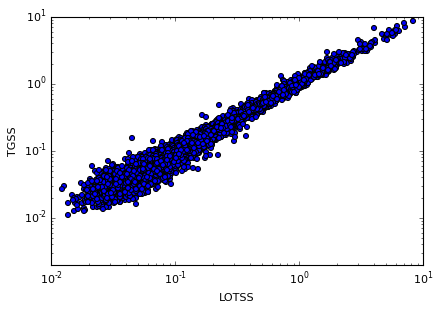

In [39]:
#Plotting Luminosities (unit Jy, log scale)

if corr>0:
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(Lum_First_Relevant, Lum_Second_Relevant)
    plt.xlabel(First_Catalogue_Name)
    plt.ylabel(Second_Catalogue_Name)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.01,10)
    plt.ylim(0,10)
    plt.show()

In [40]:
#Defining new variables
Fractional_Diff=0
n=0
m=0
Fractional_Diff_list=[]

#This loop goes through the whole lists of common sources

while n<corr-1:
    
    #Calculates nth ratio of luminosities
    Fractional_Diff=(abs(Lum_First_Relevant[n]-Lum_Second_Relevant[n]))/Lum_First_Relevant[n]
    #Creates an array of ratios
    Fractional_Diff_list.append(Fractional_Diff)
    Lum_Ratio_List.append(Lum_Ratio)
    n=n+1

#When loop is finished it will have found the biggest change in the list

0.0843640722445
0.0931777264278


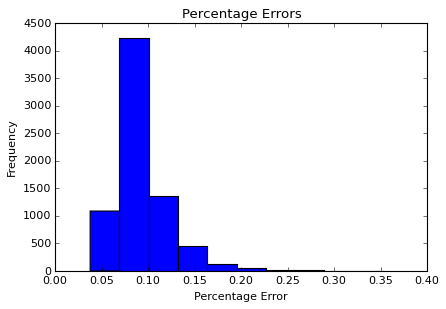

In [41]:
#Some simple statistical analyses on the code:

#Creat new array and variable
total_percentage_errors_list=[]
n=0

#This loop goes through the list of fractional changes and..
while n<len(Fractional_Diff_list):
    
    #..calculates the error on these changes before..
    error_first=(Lum_First_Relevant_e[n]/Lum_First_Relevant[n])
    
    
    total_percentage_error=error_first+((Lum_Second_Relevant_e[n]+Lum_First_Relevant_e[n])/(Lum_First_Relevant[n]+Lum_Second_Relevant[n]))
    
    #..adding them to the new list.
    total_percentage_errors_list.append(total_percentage_error)
    
    n=n+1

#Plotting the errors in a histogram
plt.hist(total_percentage_errors_list)
plt.title("Percentage Errors")
plt.xlabel("Percentage Error")
plt.ylabel("Frequency")
fig = plt.gcf()

#Calculating the mean and the median:
mean=np.mean(total_percentage_errors_list)
med= np.median(total_percentage_errors_list)
print med
print mean

In [45]:
#FIRST VARIATION

def round_to_1(x):
    return round(x, -int(floor(log10(abs(x)))))


#Number of sources with largest changes in flux you want:
size=10
#Radius you want simbad to loop at:
sim_rad='50' #in arcseconds

#Create a list of the largest changes in flux:
Largest_Fractional_Diffs=sorted(Fractional_Diff_list,reverse=True)


#Creat new lists:
Big_Change_indexes=[]
Big_Change_RAs=[]
Big_Change_DEs=[]

#Creat new variables:
n=0
m=0
RS=0
Gal=0
Qua=0
Pul=0
Oth=0

#This loop goes through the "Largest_Fractional_Diffs" list and...
while m<size:
    
    #If this loop runs through through the whole list of fractional changes 
    #before getting the specified number of results then..
    if n>=len(Largest_Fractional_Diffs):
        print "No other sources meet criterea"
        break
    
    #If it hasn't run through list then it finds indexes..
    ind= Fractional_Diff_list.index(Largest_Fractional_Diffs[n])
 
     #..then calculates the errors relating to each change
    error_first=(Lum_First_Relevant_e[ind]/Lum_First_Relevant[ind])
    error_second=(Lum_Second_Relevant_e[ind]/Lum_Second_Relevant[ind])
    total_percentage_error=error_first+((Lum_Second_Relevant_e[ind]+Lum_First_Relevant_e[ind])/(Lum_First_Relevant[ind]+Lum_Second_Relevant[ind]))
    total_error=round_to_1(total_percentage_error*Largest_Fractional_Diffs[n])
    
     #This finds all the objects on Simbad within 10" of the relevant source
    Simbad_table=Simbad.query_region(coord.SkyCoord(RA_First_Relevant[ind], DE_First_Relevant[ind],unit=(u.deg, u.deg)),radius='0d0m'+sim_rad+'s')
    
    #This loop only prints information if the percentage error on the data is below a certain threshold
    if  Largest_Fractional_Diffs[n]/total_error>=3.0:
    
        #Creates lists of their indexes and coordinates...
        Big_Change_indexes.append(ind)
        Big_Change_RAs.append(RA_First_Relevant[ind])
        Big_Change_DEs.append(DE_First_Relevant[ind])
        
        #printing relevant information:
        print m,":"
        print "Change in flux:",Largest_Fractional_Diffs[n],"±",total_error
        print "Respective fluxes:",Lum_First_Relevant[ind],Lum_Second_Relevant[ind]
        print "Coordinates:",RA_First_Relevant[ind],DE_First_Relevant[ind]
        print "Total percentage error:",round_to_1(total_percentage_error)
        print Lum_Second_Relevant[ind]/Lum_First_Relevant[ind]
        
        #If no source is found on Simbad then..
        if not Simbad_table:
            #..print this:
            print "==>no source found on SIMBAD"
        #If there is source(s) found then...
        else:
            #print relevant information from Simbad
            print Simbad_table["MAIN_ID","RA","DEC"]
            Link="http://simbad.u-strasbg.fr/simbad/sim-id?Ident="+(Simbad_table["MAIN_ID"][0].replace("+","%2B")).replace(" ", "+")+"&NbIdent=1&Radius="+sim_rad+"&Radius.unit=arcsec&submit=submit+id"
            print Link
            
            #Extracting Otype from link
            html_page = urllib2.urlopen(Link)
            soup = BeautifulSoup(html_page)
            HTML_Text=soup.get_text()
            index = HTML_Text.index("--")
            Otype=HTML_Text[index:index+25]
            
            #printing Otype
            print "Type",Otype
            
            #Finding total number of all the different types
            if 'Galaxy' in Otype:
                Gal=Gal+1
            elif 'galaxy' in Otype:
                Gal=Gal+1
            elif'BL Lac'in Otype:
                Gal=Gal+1
            elif 'Super' in Otype:
                Gal=Gal+1
            elif "Radio-source" in Otype:
                RS=RS+1
            elif "Quasar" in Otype:
                Qua=Qua+1
            elif "Pulsar" in Otype:
                Pul=Pul+1
            else:
                Oth=Oth+1
        
        #Skip some lines
        print ""
        print ""
        print ""
        m=m+1
    n=n+1

#Print what sources were found
print "Number of Radio Sources:",RS
print "Number of Galaxies:",Gal
print "Number of Quasar:",Qua
print "Number of Pulsars:",Pul
print "Number of Other Sources:",Oth

0 :
Change in flux: 2.53010156831 ± 0.3
Respective fluxes: 0.04461628 0.1575
Coordinates: 203.036 47.11892
Total percentage error: 0.1
3.53010156831
==>no source found on SIMBAD



1 :
Change in flux: 1.71487944864 ± 0.3
Respective fluxes: 0.02147425 0.0583
Coordinates: 217.38867 47.25709
Total percentage error: 0.2
2.71487944864
==>no source found on SIMBAD



2 :
Change in flux: 1.41386324135 ± 0.2
Respective fluxes: 0.02895773 0.0699
Coordinates: 206.76624 46.42481
Total percentage error: 0.1
2.41386324135
==>no source found on SIMBAD



3 :
Change in flux: 1.38031032604 ± 0.3
Respective fluxes: 0.01264541 0.0301
Coordinates: 172.18192 47.14743
Total percentage error: 0.2
2.38031032604
==>no source found on SIMBAD



4 :
Change in flux: 1.20353437537 ± 0.1
Respective fluxes: 0.04265874 0.094
Coordinates: 229.18089 48.48004
Total percentage error: 0.1
2.20353437537
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- 

In [14]:
#SECOND VARIATION

#Number of sources with largest changes in flux you want:
size=100
#Radius you want simbad to loop at:
sim_rad='10'#in arcseconds

#Create a list of the largest changes in flux:
Largest_Fractional_Diffs=sorted(Fractional_Diff_list,reverse=True)

#Creat new lists:
Big_Change_indexes=[]
Big_Change_RAs=[]
Big_Change_DEs=[]

#Creat new variables:
n=0
m=0
RS=0
Gal=0
Qua=0
Pul=0
Oth=0

#This loop goes through the "Largest_Fractional_Diffs" list and...
while m<size:
    
    #If this loop runs through through the whole list of fractional changes 
    #before getting the specified number of results then..
    if n>=len(Largest_Fractional_Diffs):
        #...print this and stop the loop
        print "No other sources meet criterea"
        break
    
    #If it hasn't run through list then it finds indexes..
    ind= Fractional_Diff_list.index(Largest_Fractional_Diffs[n])
    
     #..then calculates the errors relating to each change
    error_first=(Lum_First_Relevant_e[ind]/Lum_First_Relevant[ind])
    error_second=(Lum_Second_Relevant_e[ind]/Lum_Second_Relevant[ind])
    total_percentage_error=error_first+((Lum_Second_Relevant_e[ind]+Lum_First_Relevant_e[ind])/(Lum_First_Relevant[ind]+Lum_Second_Relevant[ind]))
    total_error=round_to_1(total_percentage_error*Largest_Fractional_Diffs[n])
    
    #This finds all the objects on Simbad within 10" of the relevant source
    Simbad_table=Simbad.query_region(coord.SkyCoord(RA_First_Relevant[ind], DE_First_Relevant[ind],unit=(u.deg, u.deg)),radius='0d0m'+sim_rad+'s')
    
    #This loop only prints information if it can be found on Simbad:
    if  Simbad_table and (Largest_Fractional_Diffs[n]/total_error)>=3.0:
        
        #Creates lists of their indexes and coordinates...
        Big_Change_indexes.append(ind)
        Big_Change_RAs.append(RA_First_Relevant[ind])
        Big_Change_DEs.append(DE_First_Relevant[ind])
        
        #printing relevant information:
        print m,":"
        print "Change in flux:",Largest_Fractional_Diffs[n],"±",total_error
        print "Respective fluxes:",Lum_First_Relevant[ind],Lum_Second_Relevant[ind]
        print "Coordinates:",RA_First_Relevant[ind],DE_First_Relevant[ind]
        print "Total percentage error:",round_to_1(total_percentage_error)
        
        #Printing Simbad information
        print Simbad_table["MAIN_ID","RA","DEC"]
        Link="http://simbad.u-strasbg.fr/simbad/sim-id?Ident="+(Simbad_table["MAIN_ID"][0].replace("+","%2B")).replace(" ", "+")+"&NbIdent=1&Radius="+sim_rad+"&Radius.unit=arcsec&submit=submit+id"
        print Link
        
        #Extracting Otype from link
        html_page = urllib2.urlopen(Link)
        soup = BeautifulSoup(html_page)
        HTML_Text=soup.get_text()
        index = HTML_Text.index("--")
        Otype=HTML_Text[index:index+25]
        
        #printing Otype
        print "Type",Otype
        
        #Finding total number of all the different types
        if 'Galaxy' in Otype:
            Gal=Gal+1
        elif 'galaxy' in Otype:
            Gal=Gal+1
        elif'BL Lac'in Otype:
            Gal=Gal+1
        elif 'Super' in Otype:
            Gal=Gal+1
        elif "Radio-source" in Otype:
            RS=RS+1
        elif "Quasar" in Otype:
            Qua=Qua+1
        elif "Pulsar" in Otype:
            Pul=Pul+1
        else:
            Oth=Oth+1
            
        #Skip some lines
        print ""
        print ""
        print ""
        m=m+1
    n=n+1
    
#Print what sources were found
print "Number of Radio Sources:",RS
print "Number of Galaxies:",Gal
print "Number of Quasar:",Qua
print "Number of Pulsars:",Pul
print "Number of Other Sources:",Oth

0 :
Change in flux: 1.20353437537 ± 0.1
Respective fluxes: 0.04265874 0.094
Coordinates: 229.18089 48.48004
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J151643+482848 15 16 43.20 +48 28 48.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J151643%2B482848&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




1 :
Change in flux: 1.20242957567 ± 0.3
Respective fluxes: 0.01216838 0.0268
Coordinates: 217.93641 46.41554
Total percentage error: 0.2
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J143144+462457 14 31 44.51 +46 24 57.1
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J143144%2B462457&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




2 :
Change in flux: 1.14764361292 ± 0.3
Respective fluxes

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:23:52.9008 +53:28:20.964': No astronomical object found :
  (error.line, error.msg))


Type -- 
Brightest galaxy in a



31 :
Change in flux: 0.581388170183 ± 0.07
Respective fluxes: 0.06582824 0.1041
Coordinates: 192.59072 45.52547
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J125021+453131 12 50 21.80 +45 31 31.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J125021%2B453131&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:16:55.1736 +49:18:04.932': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio Galaxy
       






/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:02:01.0152 +47:34:19.92': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:58:04.956 +48:35:41.82': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:13:02.4768 +54:56:03.984': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning:

32 :
Change in flux: 0.570380651656 ± 0.05
Respective fluxes: 0.05609617 0.0241
Coordinates: 201.44887 52.40183
Total percentage error: 0.09
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J132547+522405 13 25 48.00 +52 24 01.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J132547%2B522405&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




33 :
Change in flux: 0.56806780331 ± 0.05
Respective fluxes: 0.0688108 0.1079
Coordinates: 170.83853 46.33908
Total percentage error: 0.09
        MAIN_ID              RA        DEC   
                          "h:m:s"    "d:m:s" 
------------------------ ---------- ---------
WISE J112321.31+462021.2 11 23 21.3 +46 20 21
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=WISE+J112321.31%2B462021.2&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:23:10.1976 +53:01:22.764': No astronomical object found :
  (error.line, error.msg))


Type -- 
Quasar
       










34 :
Change in flux: 0.566024267294 ± 0.06
Respective fluxes: 0.05261732 0.0824
Coordinates: 207.63508 55.09872
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J135032+550556 13 50 32.76 +55 05 56.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J135032%2B550556&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:29:27.432 +56:50:37.536': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:22:02.0088 +55:50:17.448': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




35 :
Change in flux: 0.565164652061 ± 0.1
Respective fluxes: 0.02146739 0.0336
Coordinates: 190.48224 45.89258
Total percentage error: 0.2
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J124155+455328 12 41 55.70 +45 53 32.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J124155%2B455328&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:07:45.4968 +54:27:28.908': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:19:04.9008 +52:30:23.652': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




36 :
Change in flux: 0.560508434694 ± 0.06
Respective fluxes: 0.04466493 0.0697
Coordinates: 184.8218 53.11435
Total percentage error: 0.1
      MAIN_ID           RA        DEC   
                     "h:m:s"    "d:m:s" 
------------------- ---------- ---------
NVSS J121917+530652 12 19 17.2 +53 06 52
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J121917%2B530652&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:11:15.6216 +53:43:56.424': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:17:06.6912 +55:43:06.744': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




37 :
Change in flux: 0.55622070986 ± 0.02
Respective fluxes: 0.37135577 0.1648
Coordinates: 168.54529 48.31881
Total percentage error: 0.04
  MAIN_ID         RA          DEC     
               "h:m:s"      "d:m:s"   
------------ ------------ ------------
ASASSN -15so 11 14 11.037 +48 19 07.24
   NGC  3583 11 14 10.979 +48 19 06.16
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=ASASSN+-15so&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
SuperNova Candidate
 



38 :
Change in flux: 0.554706028511 ± 0.04
Respective fluxes: 0.1742669 0.0776
Coordinates: 219.22492 51.33801
Total percentage error: 0.07
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J143654+512018 14 36 54.30 +51 20 18.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J143654%2B512018&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:34:05.5776 +47:57:05.796': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




39 :
Change in flux: 0.544512389106 ± 0.03
Respective fluxes: 0.12711652 0.0579
Coordinates: 197.38968 53.49405
Total percentage error: 0.06
 MAIN_ID       RA          DEC     
            "h:m:s"      "d:m:s"   
--------- ------------ ------------
NGC  5001 13 09 33.259 +53 29 39.15
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NGC++5001&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:40:08.4864 +48:53:32.172': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:43:01.4376 +46:26:39.444': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:05:23.2608 +49:01:36.264': No astronomical object found :
  (error.line, error.msg))


Type -- 
Galaxy in Group of Ga



40 :
Change in flux: 0.542313265076 ± 0.04
Respective fluxes: 0.0790934 0.0362
Coordinates: 173.72749 49.64828
Total percentage error: 0.07
MAIN_ID     RA        DEC   
         "h:m:s"    "d:m:s" 
------- ---------- ---------
 20P 40 11 34 54.7 +49 38 52
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=20P+40&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:25:43.5384 +53:41:26.052': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:41:58.0224 +50:39:10.008': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




41 :
Change in flux: 0.542216145079 ± 0.1
Respective fluxes: 0.03585749 0.0553
Coordinates: 189.3281 45.4611
Total percentage error: 0.2
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J123718+452743 12 37 18.90 +45 27 41.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J123718%2B452743&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




42 :
Change in flux: 0.540532339508 ± 0.05
Respective fluxes: 0.03213175 0.0495
Coordinates: 193.26783 55.01915
Total percentage error: 0.1
         MAIN_ID                RA           DEC     
                             "h:m:s"       "d:m:s"   
------------------------- ------------- -------------
[VV2006] J125304.3+550108 12 53 04.3284 +55 01 08.261
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=[VV2006]+J125304.3%2B550108&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type --

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:01:14.5056 +46:51:32.328': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




44 :
Change in flux: 0.537536689784 ± 0.06
Respective fluxes: 0.04760862 0.0732
Coordinates: 183.59193 48.78124
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J121422+484653 12 14 22.04 +48 46 53.2
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J121422%2B484653&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




45 :
Change in flux: 0.537234472299 ± 0.06
Respective fluxes: 0.03911268 0.0181
Coordinates: 162.6574 47.85288
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J105037+475109 10 50 37.70 +47 51 09.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J105037%2B475109&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:57:25.9344 +53:26:00.564': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




46 :
Change in flux: 0.534885760646 ± 0.05
Respective fluxes: 0.0319242 0.049
Coordinates: 196.94528 49.65762
Total percentage error: 0.1
        MAIN_ID               RA          DEC     
                           "h:m:s"      "d:m:s"   
------------------------ ------------ ------------
SDSS J130747.20+493929.6 13 07 47.207 +49 39 29.69
     NVSS J130747+493931  13 07 47.09  +49 39 31.4
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=SDSS+J130747.20%2B493929.6&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Brightest galaxy in a



47 :
Change in flux: 0.533290238862 ± 0.05
Respective fluxes: 0.04156759 0.0194
Coordinates: 185.27521 56.40592
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J122106+562420 12 21 06.00 +56 24 20.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J122106%2B562420&NbIdent=1&Radius=10&Radi

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:13:42.924 +53:45:33.696': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:18:16.1376 +56:18:06.948': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




50 :
Change in flux: 0.528393046129 ± 0.05
Respective fluxes: 0.29685737 0.14
Coordinates: 214.02965 52.41653
Total percentage error: 0.1
       MAIN_ID              RA          DEC     
                         "h:m:s"      "d:m:s"   
---------------------- ------------ ------------
    DEEP2-GRS 12005552  14 16 07.00  +52 25 00.0
 2XMM J141606.6+522459 14 16 06.992 +52 25 00.18
[EFT2013] J1416.1+5224  14 16 06.70  +52 24 57.5
       CFDF 14h  14765 14 16 06.564 +52 24 59.66
         [GND2012] 966  14 16 06.55  +52 25 00.7
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=DEEP2-GRS+12005552&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:23:08.9976 +56:34:09.876': No astronomical object found :
  (error.line, error.msg))


Type -- 
Galaxy
       










51 :
Change in flux: 0.528333967815 ± 0.05
Respective fluxes: 0.05660785 0.0267
Coordinates: 184.54866 50.08258
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J121811+500457 12 18 11.60 +50 04 56.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J121811%2B500457&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




52 :
Change in flux: 0.526873490722 ± 0.05
Respective fluxes: 0.05262863 0.0249
Coordinates: 199.39707 55.30661
Total percentage error: 0.09
        MAIN_ID               RA          DEC     
                           "h:m:s"      "d:m:s"   
------------------------ ------------ ------------
SDSS J131735.28+551823.7 13 17 35.287 +55 18 23.75
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=SDSS+J131735.28%2B551823.7&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio G

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:38:17.1456 +51:04:23.448': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:11:08.0304 +46:06:05.148': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       






/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:09:35.7504 +48:24:23.22': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:25:13.2504 +50:13:59.412': No astronomical object found :
  (error.line, error.msg))


55 :
Change in flux: 0.518003891943 ± 0.08
Respective fluxes: 0.04920936 0.0747
Coordinates: 190.56857 45.39807
Total percentage error: 0.1
      MAIN_ID            RA        DEC   
                      "h:m:s"    "d:m:s" 
-------------------- ---------- ---------
 NVSS J124216+452354 12 42 16.6 +45 23 53
87GB 123955.8+454026   12 42 17  +45 24.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J124216%2B452354&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       






/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:11:28.5624 +55:25:10.992': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:50:41.8152 +47:32:06.936': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:50:57.5112 +45:27:13.896': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warni

56 :
Change in flux: 0.512598304117 ± 0.1
Respective fluxes: 0.04370112 0.0213
Coordinates: 211.87486 48.99348
Total percentage error: 0.2
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J140729+485935 14 07 29.80 +48 59 36.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J140729%2B485935&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




57 :
Change in flux: 0.512402782474 ± 0.05
Respective fluxes: 0.0662432 0.0323
Coordinates: 196.62526 54.24506
Total percentage error: 0.09
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J130630+541441 13 06 30.00 +54 14 42.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J130630%2B541441&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




58 :
Change in flux: 0.510644503317 ± 0.04
Respecti

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:54:36.7008 +46:53:55.176': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:02:33.996 +56:37:40.188': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




59 :
Change in flux: 0.509766170056 ± 0.05
Respective fluxes: 0.06037935 0.0296
Coordinates: 183.95352 52.41318
Total percentage error: 0.1
       MAIN_ID             RA          DEC     
                        "h:m:s"      "d:m:s"   
--------------------- ------------ ------------
2XMM J121548.7+522448 12 15 48.702 +52 24 48.91
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=2XMM+J121548.7%2B522448&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Quasar
       










60 :
Change in flux: 0.509547921255 ± 0.04
Respective fluxes: 0.05505125 0.027
Coordinates: 186.74942 49.94632
Total percentage error: 0.09
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J122659+495651 12 26 59.80 +49 56 46.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J122659%2B495651&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:07:28.32 +53:46:52.068': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




62 :
Change in flux: 0.50830491098 ± 0.04
Respective fluxes: 0.09396067 0.0462
Coordinates: 163.46368 53.17269
Total percentage error: 0.07
       MAIN_ID              RA          DEC     
                         "h:m:s"      "d:m:s"   
---------------------- ------------ ------------
FIRST J105351.6+531022 10 53 51.643 +53 10 22.50
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=FIRST+J105351.6%2B531022&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio Galaxy
       




63 :
Change in flux: 0.507507827621 ± 0.06
Respective fluxes: 0.07654944 0.0377
Coordinates: 195.38216 46.13783
Total percentage error: 0.1
        MAIN_ID               RA          DEC     
                           "h:m:s"      "d:m:s"   
------------------------ ------------ ------------
SDSS J130131.69+460815.7 13 01 31.676 +46 08 15.79
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=SDSS+J130131.69%2B460815.7&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=subm

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:39:20.2944 +54:32:43.584': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




65 :
Change in flux: 0.506402796903 ± 0.04
Respective fluxes: 0.06300684 0.0311
Coordinates: 165.27792 46.6126
Total percentage error: 0.09
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J110107+463646 11 01 06.70 +46 36 46.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J110107%2B463646&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




66 :
Change in flux: 0.506088068229 ± 0.05
Respective fluxes: 0.04555468 0.0225
Coordinates: 207.99227 55.70299
Total percentage error: 0.1
      MAIN_ID              RA           DEC     
                        "h:m:s"       "d:m:s"   
-------------------- ------------- -------------
 NVSS J135158+554211    13 51 58.2     +55 42 11
87GB 135011.8+555656 13 51 58.2006 +55 42 10.923
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J135158%2B554211&NbIdent=1&Radius=10&Radius.unit=arcse

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '15:14:42.7992 +53:21:24.624': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




67 :
Change in flux: 0.505812847381 ± 0.06
Respective fluxes: 0.04310108 0.0213
Coordinates: 172.00355 50.15493
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J112800+500920 11 28 00.80 +50 09 17.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J112800%2B500920&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       






/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:13:43.5624 +50:29:07.116': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:09:52.5936 +56:51:49.32': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:58:52.5936 +51:11:59.46': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning

68 :
Change in flux: 0.501416128899 ± 0.04
Respective fluxes: 0.07962552 0.0397
Coordinates: 199.58039 56.83339
Total percentage error: 0.07
         MAIN_ID                RA           DEC     
                             "h:m:s"       "d:m:s"   
------------------------- ------------- -------------
[VV2006] J131819.3+564959 13 18 19.2474 +56 49 59.315
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=[VV2006]+J131819.3%2B564959&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Quasar
       










69 :
Change in flux: 0.500469250974 ± 0.06
Respective fluxes: 0.02922743 0.0146
Coordinates: 173.54682 54.62743
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J113411+543740 11 34 11.20 +54 37 36.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J113411%2B543740&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:44:27.3624 +46:40:31.98': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




70 :
Change in flux: 0.498405655702 ± 0.09
Respective fluxes: 0.01474901 0.0221
Coordinates: 169.78071 48.3958
Total percentage error: 0.2
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J111907+482348 11 19 07.30 +48 23 45.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J111907%2B482348&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:19:03.6984 +49:20:22.596': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




71 :
Change in flux: 0.495501186669 ± 0.04
Respective fluxes: 0.06382572 0.0322
Coordinates: 205.36053 55.91791
Total percentage error: 0.08
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J134126+555504 13 41 26.50 +55 55 04.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J134126%2B555504&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:08:37.4088 +54:16:11.856': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:23:20.1936 +49:48:25.272': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:41:02.9424 +53:36:04.104': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




72 :
Change in flux: 0.495374375775 ± 0.05
Respective fluxes: 0.04518201 0.0228
Coordinates: 192.86989 55.1695
Total percentage error: 0.09
        MAIN_ID               RA          DEC     
                           "h:m:s"      "d:m:s"   
------------------------ ------------ ------------
SDSS J125128.76+551009.3 12 51 28.767 +55 10 09.37
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=SDSS+J125128.76%2B551009.3&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio Galaxy
       




73 :
Change in flux: 0.495276438532 ± 0.06
Respective fluxes: 0.10713738 0.1602
Coordinates: 230.17211 53.2127
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J152041+531245 15 20 41.20 +53 12 45.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J152041%2B531245&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-sou

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:28:57.8928 +52:41:34.188': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




75 :
Change in flux: 0.492758919275 ± 0.07
Respective fluxes: 0.12500344 0.1866
Coordinates: 231.31468 53.34085
Total percentage error: 0.1
      MAIN_ID            RA          DEC     
                      "h:m:s"      "d:m:s"   
------------------- ------------ ------------
NVSS J152515+532028 15 25 15.112 +53 20 28.59
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J152515%2B532028&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:19:43.9512 +56:36:12.636': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




76 :
Change in flux: 0.49179838739 ± 0.05
Respective fluxes: 0.05647365 0.0287
Coordinates: 212.41359 54.28832
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J140939+541719 14 09 39.14 +54 17 19.1
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J140939%2B541719&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:23:42.1368 +50:09:37.404': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:01:30.24 +56:06:45.18': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




77 :
Change in flux: 0.491209183618 ± 0.06
Respective fluxes: 0.05326354 0.0271
Coordinates: 181.47737 49.41911
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J120555+492508 12 05 54.50 +49 25 09.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J120555%2B492508&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




78 :
Change in flux: 0.490998284605 ± 0.07
Respective fluxes: 0.03346751 0.0499
Coordinates: 218.05574 45.84384
Total percentage error: 0.1
      MAIN_ID           RA        DEC   
                     "h:m:s"    "d:m:s" 
------------------- ---------- ---------
NVSS J143213+455037 14 32 13.3 +45 50 37
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J143213%2B455037&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




79 :
Change in flux: 0.49070

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:15:35.772 +47:46:11.964': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:28:40.7832 +49:48:30.996': No astronomical object found :
  (error.line, error.msg))


Type -- 
Quasar
       










80 :
Change in flux: 0.490162469313 ± 0.05
Respective fluxes: 0.05288014 0.0788
Coordinates: 209.48871 51.98691
Total percentage error: 0.1
        MAIN_ID               RA          DEC     
                           "h:m:s"      "d:m:s"   
------------------------ ------------ ------------
SDSS J135757.19+515912.9 13 57 57.192 +51 59 12.99
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=SDSS+J135757.19%2B515912.9&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Brightest galaxy in a



81 :
Change in flux: 0.490053386136 ± 0.08
Respective fluxes: 0.02462999 0.0367
Coordinates: 181.68784 55.62734
Total percentage error: 0.2
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J120645+553735 12 06 45.00 +55 37 38.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J120645%2B553735&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-so

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:53:27.5568 +54:31:07.608': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




84 :
Change in flux: 0.487995317026 ± 0.06
Respective fluxes: 0.04274207 0.0636
Coordinates: 173.04844 47.81084
Total percentage error: 0.1
  MAIN_ID         RA          DEC     
               "h:m:s"      "d:m:s"   
------------ ------------ ------------
LEDA 2304818 11 32 11.448 +47 48 37.52
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=LEDA+2304818&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Brightest galaxy in a



85 :
Change in flux: 0.487798689643 ± 0.08
Respective fluxes: 0.39306393 0.5848
Coordinates: 172.37106 45.34009
Total percentage error: 0.2
         MAIN_ID                RA           DEC     
                             "h:m:s"       "d:m:s"   
------------------------- ------------- -------------
[VV2006] J112929.2+452026 11 29 29.1639 +45 20 26.486
      NVSS J112929+452025    11 29 29.1     +45 20 20
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=[VV2006]+J112929.2%2B452026&NbIdent=1&Radius=10&Radius.unit=arc

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:40:10.5936 +45:34:13.476': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:02:33.9072 +54:50:31.704': No astronomical object found :
  (error.line, error.msg))


Type -- 
Brightest galaxy in a



88 :
Change in flux: 0.485448000342 ± 0.05
Respective fluxes: 0.06821468 0.0351
Coordinates: 185.14518 50.7491
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J122034+504457 12 20 34.80 +50 44 57.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J122034%2B504457&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id


/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:58:43.7664 +56:27:30.996': No astronomical object found :
  (error.line, error.msg))


Type -- 
Radio-source
       




89 :
Change in flux: 0.484856934736 ± 0.04
Respective fluxes: 0.07473652 0.0385
Coordinates: 214.5726 46.44813
Total percentage error: 0.09
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J141817+462651 14 18 17.60 +46 26 53.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J141817%2B462651&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




90 :
Change in flux: 0.483984927426 ± 0.06
Respective fluxes: 0.04864199 0.0251
Coordinates: 183.53716 46.54595
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J121409+463246 12 14 08.80 +46 32 44.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J121409%2B463246&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




91 :
Change in f

/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '11:13:28.8312 +55:14:50.028': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '14:14:27.6432 +55:12:13.392': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:43:59.4816 +45:06:37.692': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warni

96 :
Change in flux: 0.478694144373 ± 0.04
Respective fluxes: 0.65679573 0.9712
Coordinates: 226.02928 53.1186
Total percentage error: 0.09
      MAIN_ID           RA        DEC   
                     "h:m:s"    "d:m:s" 
------------------- ---------- ---------
NVSS J150407+530706 15 04 07.1 +53 07 06
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J150407%2B530706&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       






/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '10:49:59.1264 +53:00:34.344': No astronomical object found :
  (error.line, error.msg))
/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '12:40:59.9352 +54:59:40.92': No astronomical object found :
  (error.line, error.msg))


97 :
Change in flux: 0.478578603058 ± 0.05
Respective fluxes: 0.09033001 0.0471
Coordinates: 177.09231 48.22499
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J114822+481329 11 48 22.00 +48 13 29.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J114822%2B481329&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       






/Users/niallbradley/anaconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '13:36:54.0984 +52:43:10.056': No astronomical object found :
  (error.line, error.msg))


98 :
Change in flux: 0.478028338216 ± 0.06
Respective fluxes: 0.02855155 0.0422
Coordinates: 212.10171 46.72713
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J140824+464337 14 08 24.40 +46 43 37.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J140824%2B464337&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




99 :
Change in flux: 0.477122088365 ± 0.07
Respective fluxes: 0.0343235 0.0507
Coordinates: 216.95735 55.55559
Total percentage error: 0.1
      MAIN_ID            RA          DEC     
                      "h:m:s"      "d:m:s"   
------------------- ------------ ------------
NVSS J142749+553320 14 27 49.717 +55 33 18.92
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J142749%2B553320&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




Number of Radio Sources: 67
Number of Galax

In [15]:
#THIRD VARIATION

#Number of sources with largest changes in flux you want:
size=10
#Radius you want simbad to loop at:
sim_rad='10' #in arcseconds

#Create a list of the largest fractional changes in flux:
Largest_Fractional_Diffs=sorted(Fractional_Diff_list,reverse=True)

#Creat new lists:
Big_Change_indexes=[]
Big_Change_RAs=[]
Big_Change_DEs=[]

#Creat new variables:
n=0
m=0
RS=0
Gal=0
Qua=0
Pul=0
Oth=0

#This loop goes through the "Largest_Fractional_Diffs" list and...
while m<size:
    
    #If this loop runs through through the whole list of fractional changes 
    #before getting the specified number of results then..
    if n>=len(Largest_Fractional_Diffs):
        print "No other sources meet criterea"
        break
    
    #If it hasn't run through list then it finds indexes..
    ind= Fractional_Diff_list.index(Largest_Fractional_Diffs[n])
 
     #..then calculates the errors relating to each change
    error_first=(Lum_First_Relevant_e[ind]/Lum_First_Relevant[ind])
    error_second=(Lum_Second_Relevant_e[ind]/Lum_Second_Relevant[ind])
    total_percentage_error=error_first+((Lum_Second_Relevant_e[ind]+Lum_First_Relevant_e[ind])/(Lum_First_Relevant[ind]+Lum_Second_Relevant[ind]))
    total_error=round_to_1(total_percentage_error*Largest_Fractional_Diffs[n])
    
     #This finds all the objects on Simbad within 10" of the relevant source
    Simbad_table=Simbad.query_region(coord.SkyCoord(RA_First_Relevant[ind], DE_First_Relevant[ind],unit=(u.deg, u.deg)),radius='0d0m'+sim_rad+'s')
    
    #This loop only prints information if the percentage error on the data is below a certain threshold
    if  total_percentage_error<=0.1 and (Largest_Fractional_Diffs[n]/total_error)>=3.0:
    
        #Creates lists of their indexes and coordinates...
        Big_Change_indexes.append(ind)
        Big_Change_RAs.append(RA_First_Relevant[ind])
        Big_Change_DEs.append(DE_First_Relevant[ind])
        
        #printing relevant information:
        print m,":"
        print "Change in flux:",Largest_Fractional_Diffs[n],"±",total_error
        print "Respective fluxes:",Lum_First_Relevant[ind],Lum_Second_Relevant[ind]
        print "Coordinates:",RA_First_Relevant[ind],DE_First_Relevant[ind]
        print "Total percentage error:",round_to_1(total_percentage_error)
        
        #If no source is found on Simbad then..
        if not Simbad_table:
            #..print this:
            print "==>no source found on SIMBAD"
        #If there is source(s) found then...
        else:
            #print relevant information from Simbad
            print Simbad_table["MAIN_ID","RA","DEC"]
            Link="http://simbad.u-strasbg.fr/simbad/sim-id?Ident="+(Simbad_table["MAIN_ID"][0].replace("+","%2B")).replace(" ", "+")+"&NbIdent=1&Radius="+sim_rad+"&Radius.unit=arcsec&submit=submit+id"
            print Link
            
            #Extracting Otype from link
            html_page = urllib2.urlopen(Link)
            soup = BeautifulSoup(html_page)
            HTML_Text=soup.get_text()
            index = HTML_Text.index("--")
            Otype=HTML_Text[index:index+25]
            
            #printing Otype
            print "Type",Otype
            
            #Finding total number of all the different types
            if 'Galaxy' in Otype:
                Gal=Gal+1
            elif 'galaxy' in Otype:
                Gal=Gal+1
            elif'BL Lac'in Otype:
                Gal=Gal+1
            elif 'Super' in Otype:
                Gal=Gal+1
            elif "Radio-source" in Otype:
                RS=RS+1
            elif "Quasar" in Otype:
                Qua=Qua+1
            elif "Pulsar" in Otype:
                Pul=Pul+1
            else:
                Oth=Oth+1
        
        #Skip some lines
        print ""
        print ""
        print ""
        m=m+1
    n=n+1
    
#Print what sources were found
print "Number of Radio Sources:",RS
print "Number of Galaxies:",Gal
print "Number of Quasar:",Qua
print "Number of Pulsars:",Pul
print "Number of Other Sources:",Oth

0 :
Change in flux: 0.810995328782 ± 0.08
Respective fluxes: 0.041745 0.0756
Coordinates: 196.56695 49.70918
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J130616+494234 13 06 16.00 +49 42 33.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J130616%2B494234&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




1 :
Change in flux: 0.658090030701 ± 0.05
Respective fluxes: 0.09300694 0.0318
Coordinates: 183.68359 54.58016
Total percentage error: 0.07
==>no source found on SIMBAD



2 :
Change in flux: 0.657098924163 ± 0.06
Respective fluxes: 0.15368864 0.0527
Coordinates: 186.47155 53.15344
Total percentage error: 0.08
==>no source found on SIMBAD



3 :
Change in flux: 0.619915950369 ± 0.05
Respective fluxes: 0.07051072 0.0268
Coordinates: 201.21004 56.65039
Total percentage error: 0.08
==>no source found on SIMBAD



4 :
Change i

In [21]:
#FOURTH VARIATION

#Number of sources with largest changes in flux you want:
size=130
#Radius you want simbad to loop at:
sim_rad='10' #in arcseconds

#Create a list of the largest fractional changes in flux:
Largest_Fractional_Diffs=sorted(Fractional_Diff_list,reverse=True)

#Creat new lists:
Big_Change_indexes=[]
Big_Change_RAs=[]
Big_Change_DEs=[]

#Creat new variables:
n=0
m=0
RS=0
Gal=0
Qua=0
Pul=0
Oth=0

#This loop goes through the "Largest_Fractional_Diffs" list and...
while m<size:
    
    #If this loop runs through through the whole list of fractional changes 
    #before getting the specified number of results then..
    if n>=len(Largest_Fractional_Diffs):
        print "No other sources meet criterea"
        break
    
    #If it hasn't run through list then it finds indexes..
    ind= Fractional_Diff_list.index(Largest_Fractional_Diffs[n])
 
     #..then calculates the errors relating to each change
    error_first=(Lum_First_Relevant_e[ind]/Lum_First_Relevant[ind])
    error_second=(Lum_Second_Relevant_e[ind]/Lum_Second_Relevant[ind])
    total_percentage_error=error_first+((Lum_Second_Relevant_e[ind]+Lum_First_Relevant_e[ind])/(Lum_First_Relevant[ind]+Lum_Second_Relevant[ind]))
    total_error=round_to_1(total_percentage_error*Largest_Fractional_Diffs[n])
    
     #This finds all the objects on Simbad within 10" of the relevant source
    #Simbad_table=Simbad.query_region(coord.SkyCoord(RA_First_Relevant[ind], DE_First_Relevant[ind],unit=(u.deg, u.deg)),radius='0d0m'+sim_rad+'s')
    try:
        Simbad_table=Simbad.query_region(coord.SkyCoord(RA_First_Relevant[ind], DE_First_Relevant[ind],unit=(u.deg, u.deg)),radius='0d0m'+sim_rad+'s')
    except EOFError:
        print "EOFError"
        n=n+1
        continue
        
    
    #This loop only prints information if the percentage error on the data is below a certain threshold
    #And there's data available on Simbad
    if  total_percentage_error<=0.1 and Simbad_table and (Largest_Fractional_Diffs[n]/total_error)>=3.0:
    
        #Creates lists of their indexes and coordinates...
        Big_Change_indexes.append(ind)
        Big_Change_RAs.append(RA_First_Relevant[ind])
        Big_Change_DEs.append(DE_First_Relevant[ind])
        
        #printing relevant information:
        print m,":"
        print "Change in flux:",Largest_Fractional_Diffs[n],"±",total_error
        print "Respective fluxes:",Lum_First_Relevant[ind],Lum_Second_Relevant[ind]
        print "Coordinates:",RA_First_Relevant[ind],DE_First_Relevant[ind]
        print "Total percentage error:",round_to_1(total_percentage_error)
        

        #print relevant information from Simbad
        print Simbad_table["MAIN_ID","RA","DEC"]
        Link="http://simbad.u-strasbg.fr/simbad/sim-id?Ident="+(Simbad_table["MAIN_ID"][0].replace("+","%2B")).replace(" ", "+")+"&NbIdent=1&Radius="+sim_rad+"&Radius.unit=arcsec&submit=submit+id"
        print Link
        
        #Extracting Otype from link
        html_page = urllib2.urlopen(Link)
        soup = BeautifulSoup(html_page)
        HTML_Text=soup.get_text()
        index = HTML_Text.index("--")
        Otype=HTML_Text[index:index+25]
        
        #printing Otype
        print "Type",Otype
        
        #Finding total number of all the different types
        if 'Galaxy' in Otype:
            Gal=Gal+1
        elif 'galaxy' in Otype:
            Gal=Gal+1
        elif'BL Lac'in Otype:
            Gal=Gal+1
        elif 'Super' in Otype:
            Gal=Gal+1
        elif "Radio-source" in Otype:
            RS=RS+1
        elif "Quasar" in Otype:
            Qua=Qua+1
        elif "Pulsar" in Otype:
            Pul=Pul+1
        else:
            Oth=Oth+1
            
        #Skip some lines
        print ""
        print ""
        print ""
        m=m+1
    n=n+1
    
#Print what sources were found
print "Number of Radio Sources:",RS
print "Number of Galaxies:",Gal
print "Number of Quasar:",Qua
print "Number of Pulsars:",Pul
print "Number of Other Sources:",Oth

0 :
Change in flux: 0.810995328782 ± 0.08
Respective fluxes: 0.041745 0.0756
Coordinates: 196.56695 49.70918
Total percentage error: 0.1
      MAIN_ID            RA         DEC    
                      "h:m:s"     "d:m:s"  
------------------- ----------- -----------
NVSS J130616+494234 13 06 16.00 +49 42 33.0
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NVSS+J130616%2B494234&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Radio-source
       




1 :
Change in flux: 0.611234084466 ± 0.05
Respective fluxes: 0.05709909 0.092
Coordinates: 211.90289 48.62731
Total percentage error: 0.09
         MAIN_ID                RA           DEC     
                             "h:m:s"       "d:m:s"   
------------------------- ------------- -------------
[VV2010] J140736.7+483737 14 07 36.6473 +48 37 37.500
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=[VV2010]+J140736.7%2B483737&NbIdent=1&Radius=10&Radius.unit=arcsec&submit=submit+id
Type -- 
Quasar
       










2 :
Chan

In [22]:
# #FIFTH VARIATION

# #Number of sources with largest changes in flux you want:
# size=10
# #Radius you want simbad to loop at:
# sim_rad='10' #in arcseconds

# #Create a list of the largest fractional changes in flux:
# Largest_Fractional_Diffs=sorted(Fractional_Diff_list,reverse=True)

# #Creat new lists:
# Big_Change_indexes=[]
# Big_Change_RAs=[]
# Big_Change_DEs=[]

# #Creat new variables:
# n=0
# m=0
# i=0

# #This loop goes through the "Largest_Fractional_Diffs" list and...
# while m<3:
    
#     #If this loop runs through through the whole list of fractional changes 
#     #before getting the specified number of results then..
#     if n>=len(Largest_Fractional_Diffs):
#         print "No other sources meet criterea"
#         break
    
#     #If it hasn't run through list then it finds indexes..
#     ind= Fractional_Diff_list.index(Largest_Fractional_Diffs[n])
 
#      #..then calculates the errors relating to each change
#     error_first=(Lum_First_Relevant_e[ind]/Lum_First_Relevant[ind])
#     error_second=(Lum_Second_Relevant_e[ind]/Lum_Second_Relevant[ind])
#     total_percentage_error=error_first+((Lum_Second_Relevant_e[ind]+Lum_First_Relevant_e[ind])/(Lum_First_Relevant[ind]+Lum_Second_Relevant[ind]))
#     total_error=round_to_1(total_percentage_error*Largest_Fractional_Diffs[n])
    
#      #This finds all the objects on Simbad within 10" of the relevant source
#     #Simbad_table=Simbad.query_region(coord.SkyCoord(RA_First_Relevant[ind], DE_First_Relevant[ind],unit=(u.deg, u.deg)),radius='0d0m'+sim_rad+'s')
#     try:
#         Simbad_table=Simbad.query_region(coord.SkyCoord(RA_First_Relevant[ind], DE_First_Relevant[ind],unit=(u.deg, u.deg)),radius='0d0m'+sim_rad+'s')
#     except:
#         print "EOFError"
#         n=n+1
#         continue
        
    
#     #This loop only prints information if the percentage error on the data is below a certain threshold
#     #And there's data available on Simbad
#     if   Simbad_table :
#         Link="http://simbad.u-strasbg.fr/simbad/sim-id?Ident="+(Simbad_table["MAIN_ID"][0].replace("+","%2B")).replace(" ", "+")+"&NbIdent=1&Radius="+sim_rad+"&Radius.unit=arcsec&submit=submit+id"
        
#         #Extracting Otype from link
#         html_page = urllib2.urlopen(Link)
#         soup = BeautifulSoup(html_page)
#         HTML_Text=soup.get_text()
#         index = HTML_Text.index("--")
#         Otype=HTML_Text[index:index+25]
        
#         #print Boring_Types[i]
        
#         Boring_Types=["Galaxy","galaxy","Quasar","Super","Radio-source","BL Lac"]
#         if Boring_Types[i] in Otype:
#             n=n+1
#             i=0
#             continue
#         elif i+1<len(Boring_Types):
#             i=i+1
#             continue
#         else:
#             #Creates lists of their indexes and coordinates...
#             Big_Change_indexes.append(ind)
#             Big_Change_RAs.append(RA_First_Relevant[ind])
#             Big_Change_DEs.append(DE_First_Relevant[ind])
        
#             #printing relevant information:
#             print m,":"
#             print "Change in flux:",Largest_Fractional_Diffs[n],"±",total_error
#             print "Respective fluxes:",Lum_First_Relevant[ind],Lum_Second_Relevant[ind]
#             print "Coordinates:",RA_First_Relevant[ind],DE_First_Relevant[ind]
#             print "Total percentage error:",round_to_1(total_percentage_error)
        

#             #print relevant information from Simbad
#             print Simbad_table["MAIN_ID","RA","DEC"]
#             print Link
        
#             #printing Otype
#             print "Type",Otype
        
            
#             #Skip some lines
#             print ""
#             print ""
#             print ""
#             m=m+1
#             n=n+1
#             i=0
#     else:
#         n=n+1

/Users/niallbradley/anaconda/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:


INFO: Auto-setting vmin to  2.553e+03 [aplpy.core]
INFO: Auto-setting vmax to  4.181e+03 [aplpy.core]


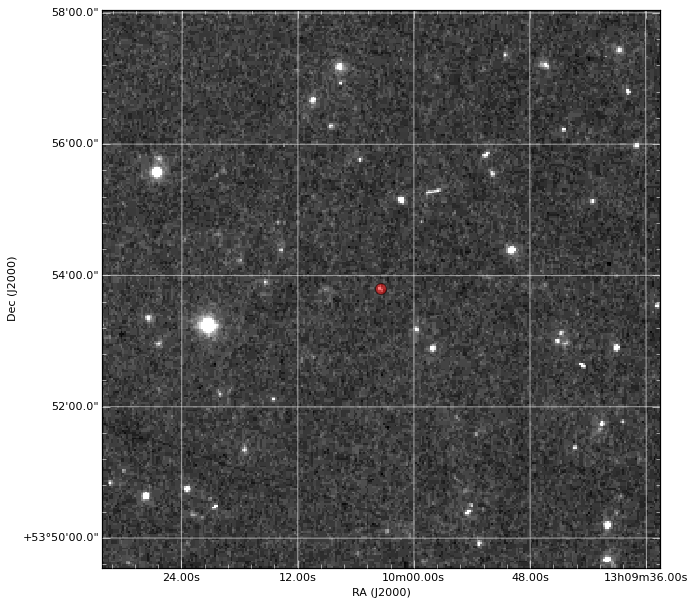

In [23]:
#This displays image of a correlated source

#Which source to show:
x=2

#Coordinates of this star:
pos=coord.SkyCoord(Big_Change_RAs[x]*u.deg, Big_Change_DEs[x]*u.deg)
ra=np.array([Big_Change_RAs[x]])
de=np.array([Big_Change_DEs[x]])
#Find image from DSS:
images = SkyView.get_images(pos,survey=['DSS'])
print images[0]

CV = aplpy.FITSFigure(images[0])


#Gives in grid and makes it grayscale (can also be made colorscale)
CV.show_grayscale()
CV.add_grid()

#This plots a circle where the relevant source should be 
x_pix, y_pix = CV.world2pixel(ra,de)
plt.scatter(x_pix, y_pix, s=100, c='red', alpha=.5)
plt.show()

In [ ]:
for x in range(10):
    print x,":"
    print ""


    #Coordinates of this star:
    pos=coord.SkyCoord(Big_Change_RAs[x]*u.deg, Big_Change_DEs[x]*u.deg)
    ra=np.array([Big_Change_RAs[x]])
    de=np.array([Big_Change_DEs[x]])
    #Find image from DSS:
    images = SkyView.get_images(pos,survey=['DSS'])
    print images[0]

    CV = aplpy.FITSFigure(images[0])


    #Gives in grid and makes it grayscale (can also be made colorscale)
    CV.show_grayscale()
    CV.add_grid()

    #This plots a circle where the relevant source should be 
    x_pix, y_pix = CV.world2pixel(ra,de)
    plt.scatter(x_pix, y_pix, s=100, c='red', alpha=.5)
    plt.show()